## Ultimate Challenge Predictive Modeling 

In [39]:
#Importing Libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime 
import missingno as msn


from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
#importing the dataset
df=pd.read_json('ultimate_data_challenge.json')
df.head(3)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.1,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.0,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.0,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0


### 1. User Retention

In [3]:
#The last trip date recorded
df['last_trip_date'].max()

'2014-07-01'

A user retained will be a user who will be active in the preceding 30days which means a user who will be active after 2014-06-01

#### 1. 1 User retention percentage

In [4]:
df['user_retained']=[x>'2014-06-01' for x in df.last_trip_date]

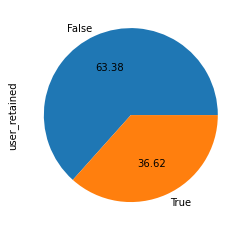

In [5]:
df['user_retained'].value_counts().plot.pie(autopct='%.2f');

36.62% of users are considered retained 

#### 1.2 Retention accross cities

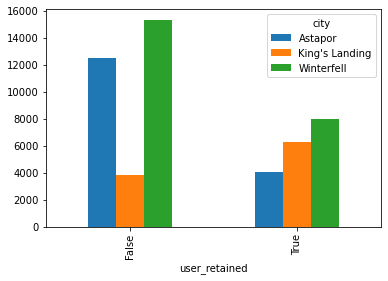

In [6]:
df.groupby(['user_retained'])['city'].value_counts().unstack().plot.bar();

In [7]:
# Ratio (fraction) of user retention accross cites
df.groupby(['user_retained'])['city'].value_counts()[1]/df.groupby(['user_retained'])['city'].value_counts()[0]

city
Astapor           0.321451
King's Landing    1.649752
Winterfell        0.519766
Name: city, dtype: float64

King's Landing have a high ratio of user retained whereas in Astapor majority of users have not been active in last 30 days 

### 2. Predictive Model

In [8]:
# days (in order to calculate the dates in the sixth month of user's signup dates)
days_150=datetime.timedelta(days=150)

In [9]:
df['last_trip_date']=pd.to_datetime(df['last_trip_date'])
df['signup_date']=pd.to_datetime(df['signup_date'])

In [10]:
df['sixth_month']=df['signup_date']+days_150

In [11]:
# We can use the column above to see a user is active within his/her sixth month (True=1, False=0)
df['active']=np.where(df['last_trip_date']>df['sixth_month'], 1, 0)

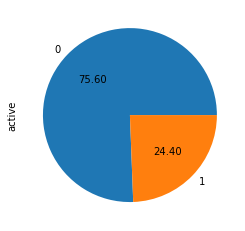

In [12]:
# Only 24.4% percent are still active in their sixth month
df['active'].value_counts().plot.pie(autopct='%.2f');

#### 2.1 Replacing categorical data with numerical ones

In [13]:
df['city']=df['city'].replace(['Astapor',"King's Landing",'Winterfell'],[0,1,2])
df['phone']=df['phone'].replace(['iPhone', 'Android'],[1,0])
df['ultimate_black_user']=df['ultimate_black_user'].replace([True, False],[1,0])
df['user_retained']=df['user_retained'].replace([True, False],[1,0])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  int64         
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  float64       
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  int64         
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  user_retained           50000 non-null  int64 

#### 2.2 Missing Values

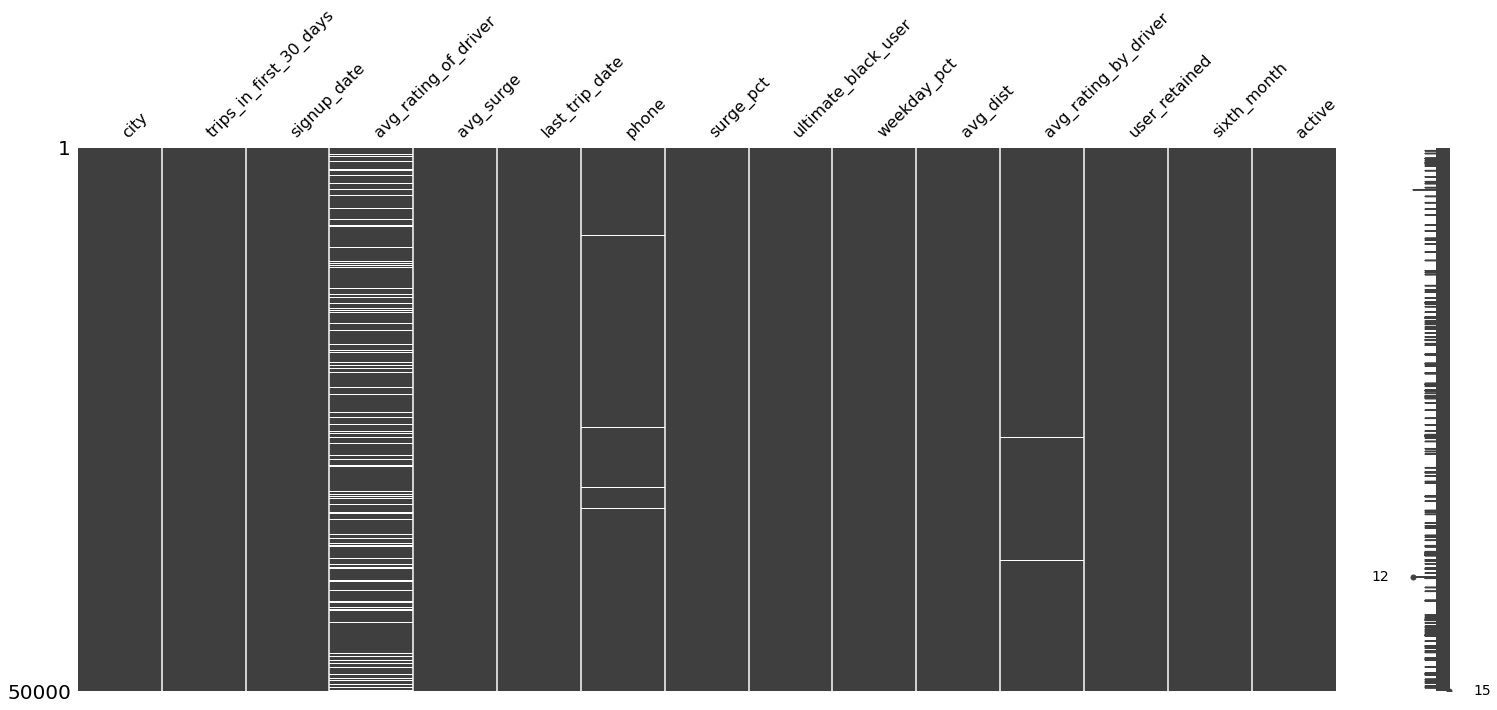

In [15]:
msn.matrix(df);

In [16]:
#filling missing values
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df['phone'].fillna(1, inplace=True)
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)

In [17]:
df.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
user_retained             0
sixth_month               0
active                    0
dtype: int64

#### 2.3 Selecting features

In [18]:
features=['city', 'trips_in_first_30_days', 'avg_rating_of_driver',
       'avg_surge','phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver']

In [19]:
X=df[features]
y=df['active']

#### 2.4 Splitting the dataset into train and test sets

In [20]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=2)

In [21]:
X_train.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
5478,2,1,5.0,1.0,1.0,0.0,0,33.3,23.35,5.0
22132,2,1,5.0,1.0,1.0,0.0,1,50.0,8.04,5.0
33533,2,4,5.0,1.0,1.0,0.0,0,16.7,5.68,4.2
42605,1,1,3.0,1.0,0.0,0.0,0,0.0,15.47,5.0
48740,2,4,5.0,1.0,1.0,0.0,1,57.1,9.27,5.0


In [22]:
y_train

5478     0
22132    0
33533    0
42605    0
48740    0
        ..
44566    0
30280    1
6637     0
35343    0
23720    1
Name: active, Length: 40000, dtype: int32

#### 2.5 Modeling

In [23]:
tpot= TPOTClassifier(generations=1,verbosity=2,random_state=42)
tpot.fit(X_train,y_train)


Generation 1 - Current best internal CV score: 0.8020249999999999

Best pipeline: XGBClassifier(BernoulliNB(input_matrix, alpha=10.0, fit_prior=True), learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=100, n_jobs=1, subsample=0.55, verbosity=0)


TPOTClassifier(generations=1, random_state=42, verbosity=2)

In [26]:
# Model performance on the test data
print(tpot.score(X_test, y_test))

0.7994


#### 2.6 Feature Importance

In [29]:
model=XGBClassifier()
model.fit(X_train,y_train)

C:\Users\write\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
print(model.feature_importances_)

[0.11955031 0.0484695  0.03721412 0.04664757 0.18923897 0.1326604
 0.08602503 0.08123655 0.03205961 0.22689797]


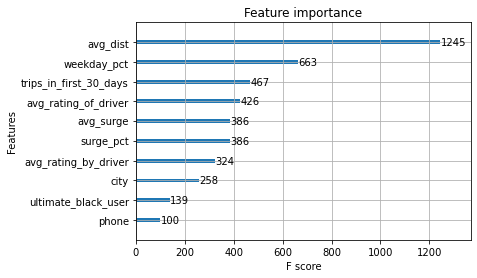

In [41]:
plot_importance(model);

The model shows that the most important features are:
- avg_dist: Average distance in miles per trip taken in the first 30 days after signup, 
- weekday_pct:the percent of the user’s trips occurring during a weekday
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up


As the import features of the model show, it is important to make trips in the first 30 days more enjoyable for example by offering a discount for the first month